In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [16]:
with np.load("root_files/combined_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [17]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [18]:
del feature_array, label_array

In [19]:
with np.load("root_files/combined_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [20]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [21]:
del feature_array_test, label_array_test

In [22]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [23]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 49)
(11734326, 49)
(1467277, 49)
(1467277, 49)


In [24]:
del bkg, sig, bkg_test, sig_test, df

In [25]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [26]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 49)
(1782913, 49)
(222732, 49)
(222732, 49)


  0%|          | 0/48 [00:00<?, ?it/s]

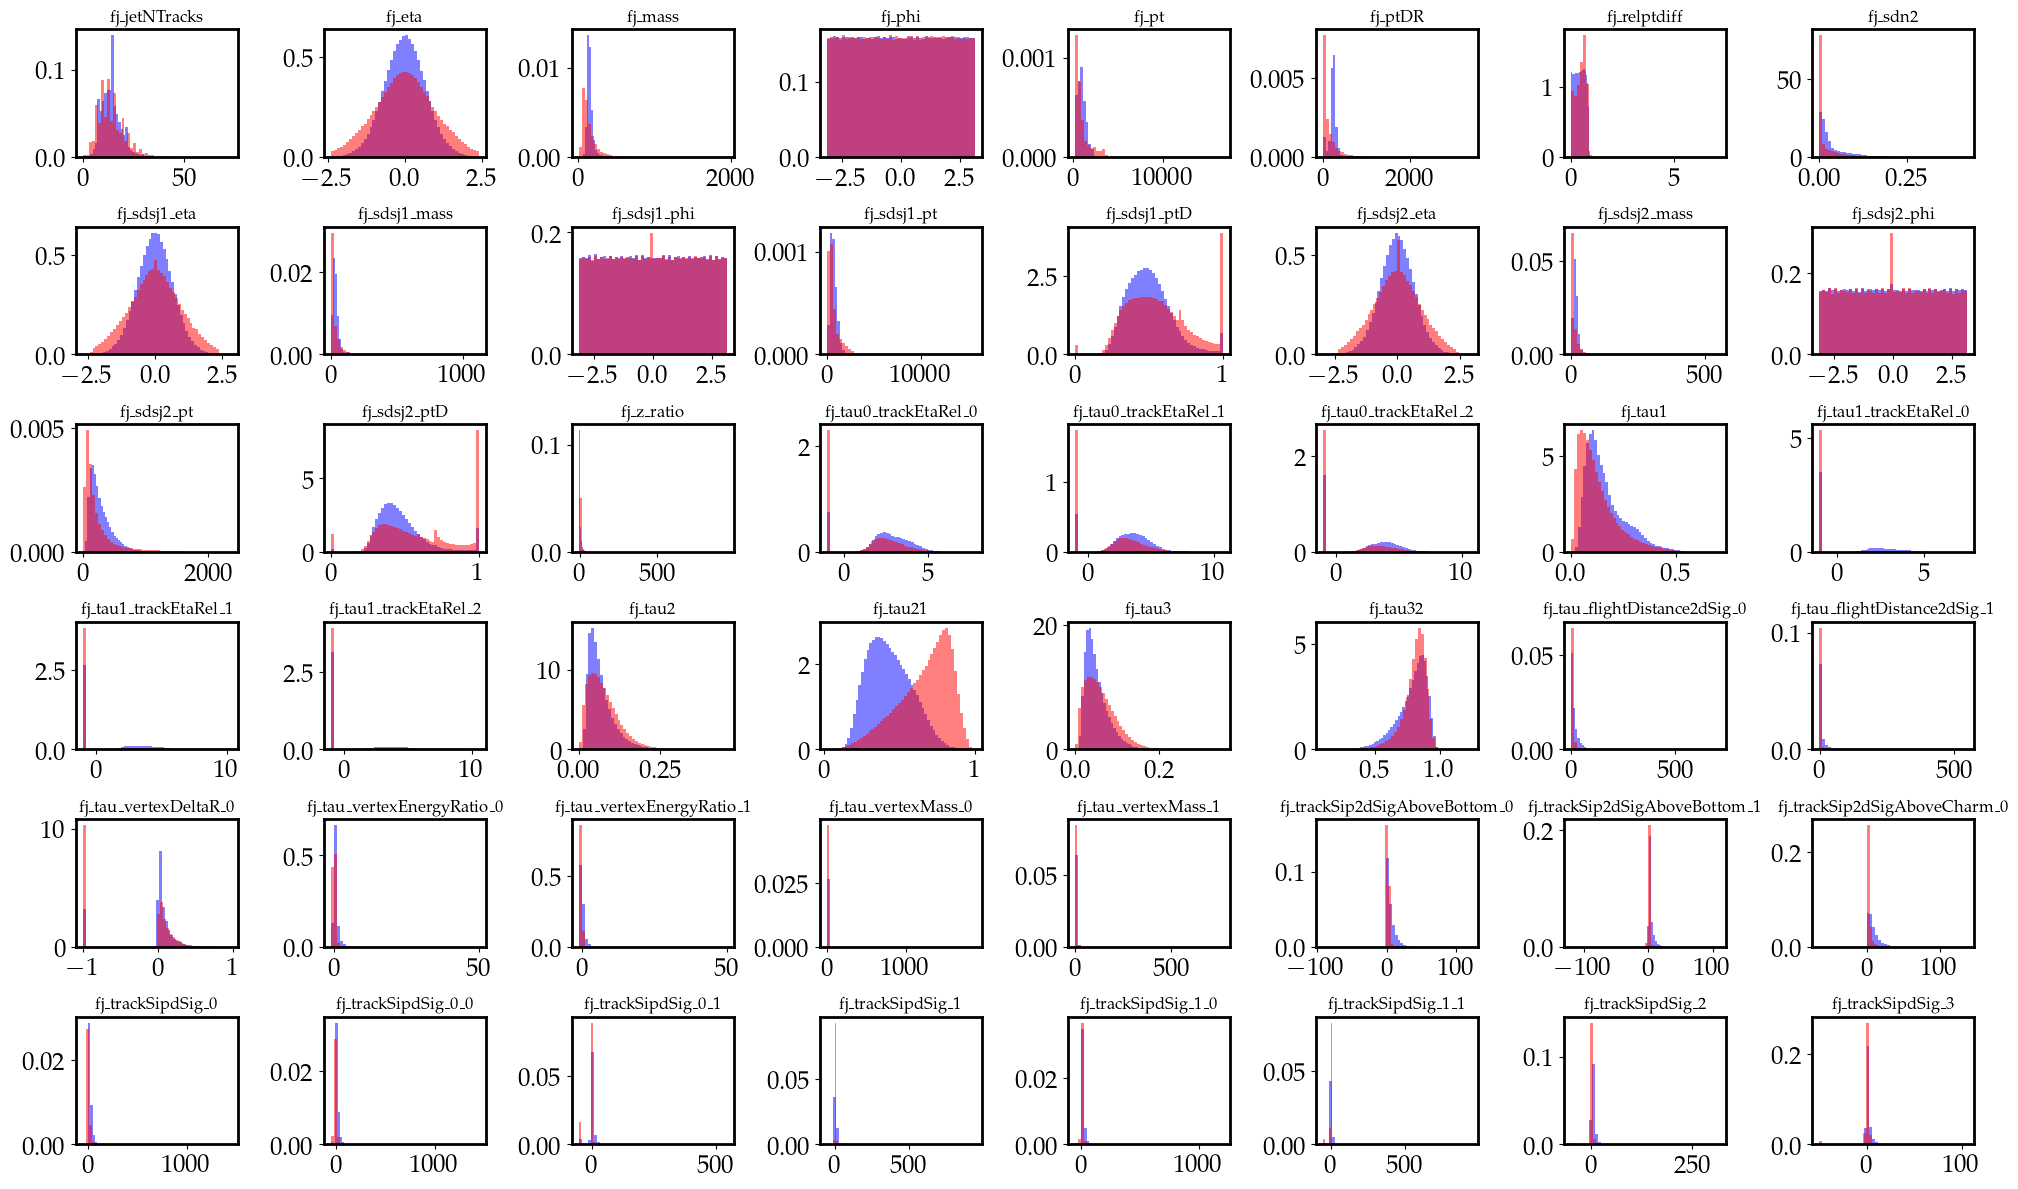

In [31]:
fig, axes = plt.subplots(6,8, figsize=(20,12))

features_to_plot = sig_train_out.columns.drop('fj_nSV')

for ax, label in tqdm(zip(axes.ravel(), features_to_plot), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('plots/hists.pdf')
plt.show()

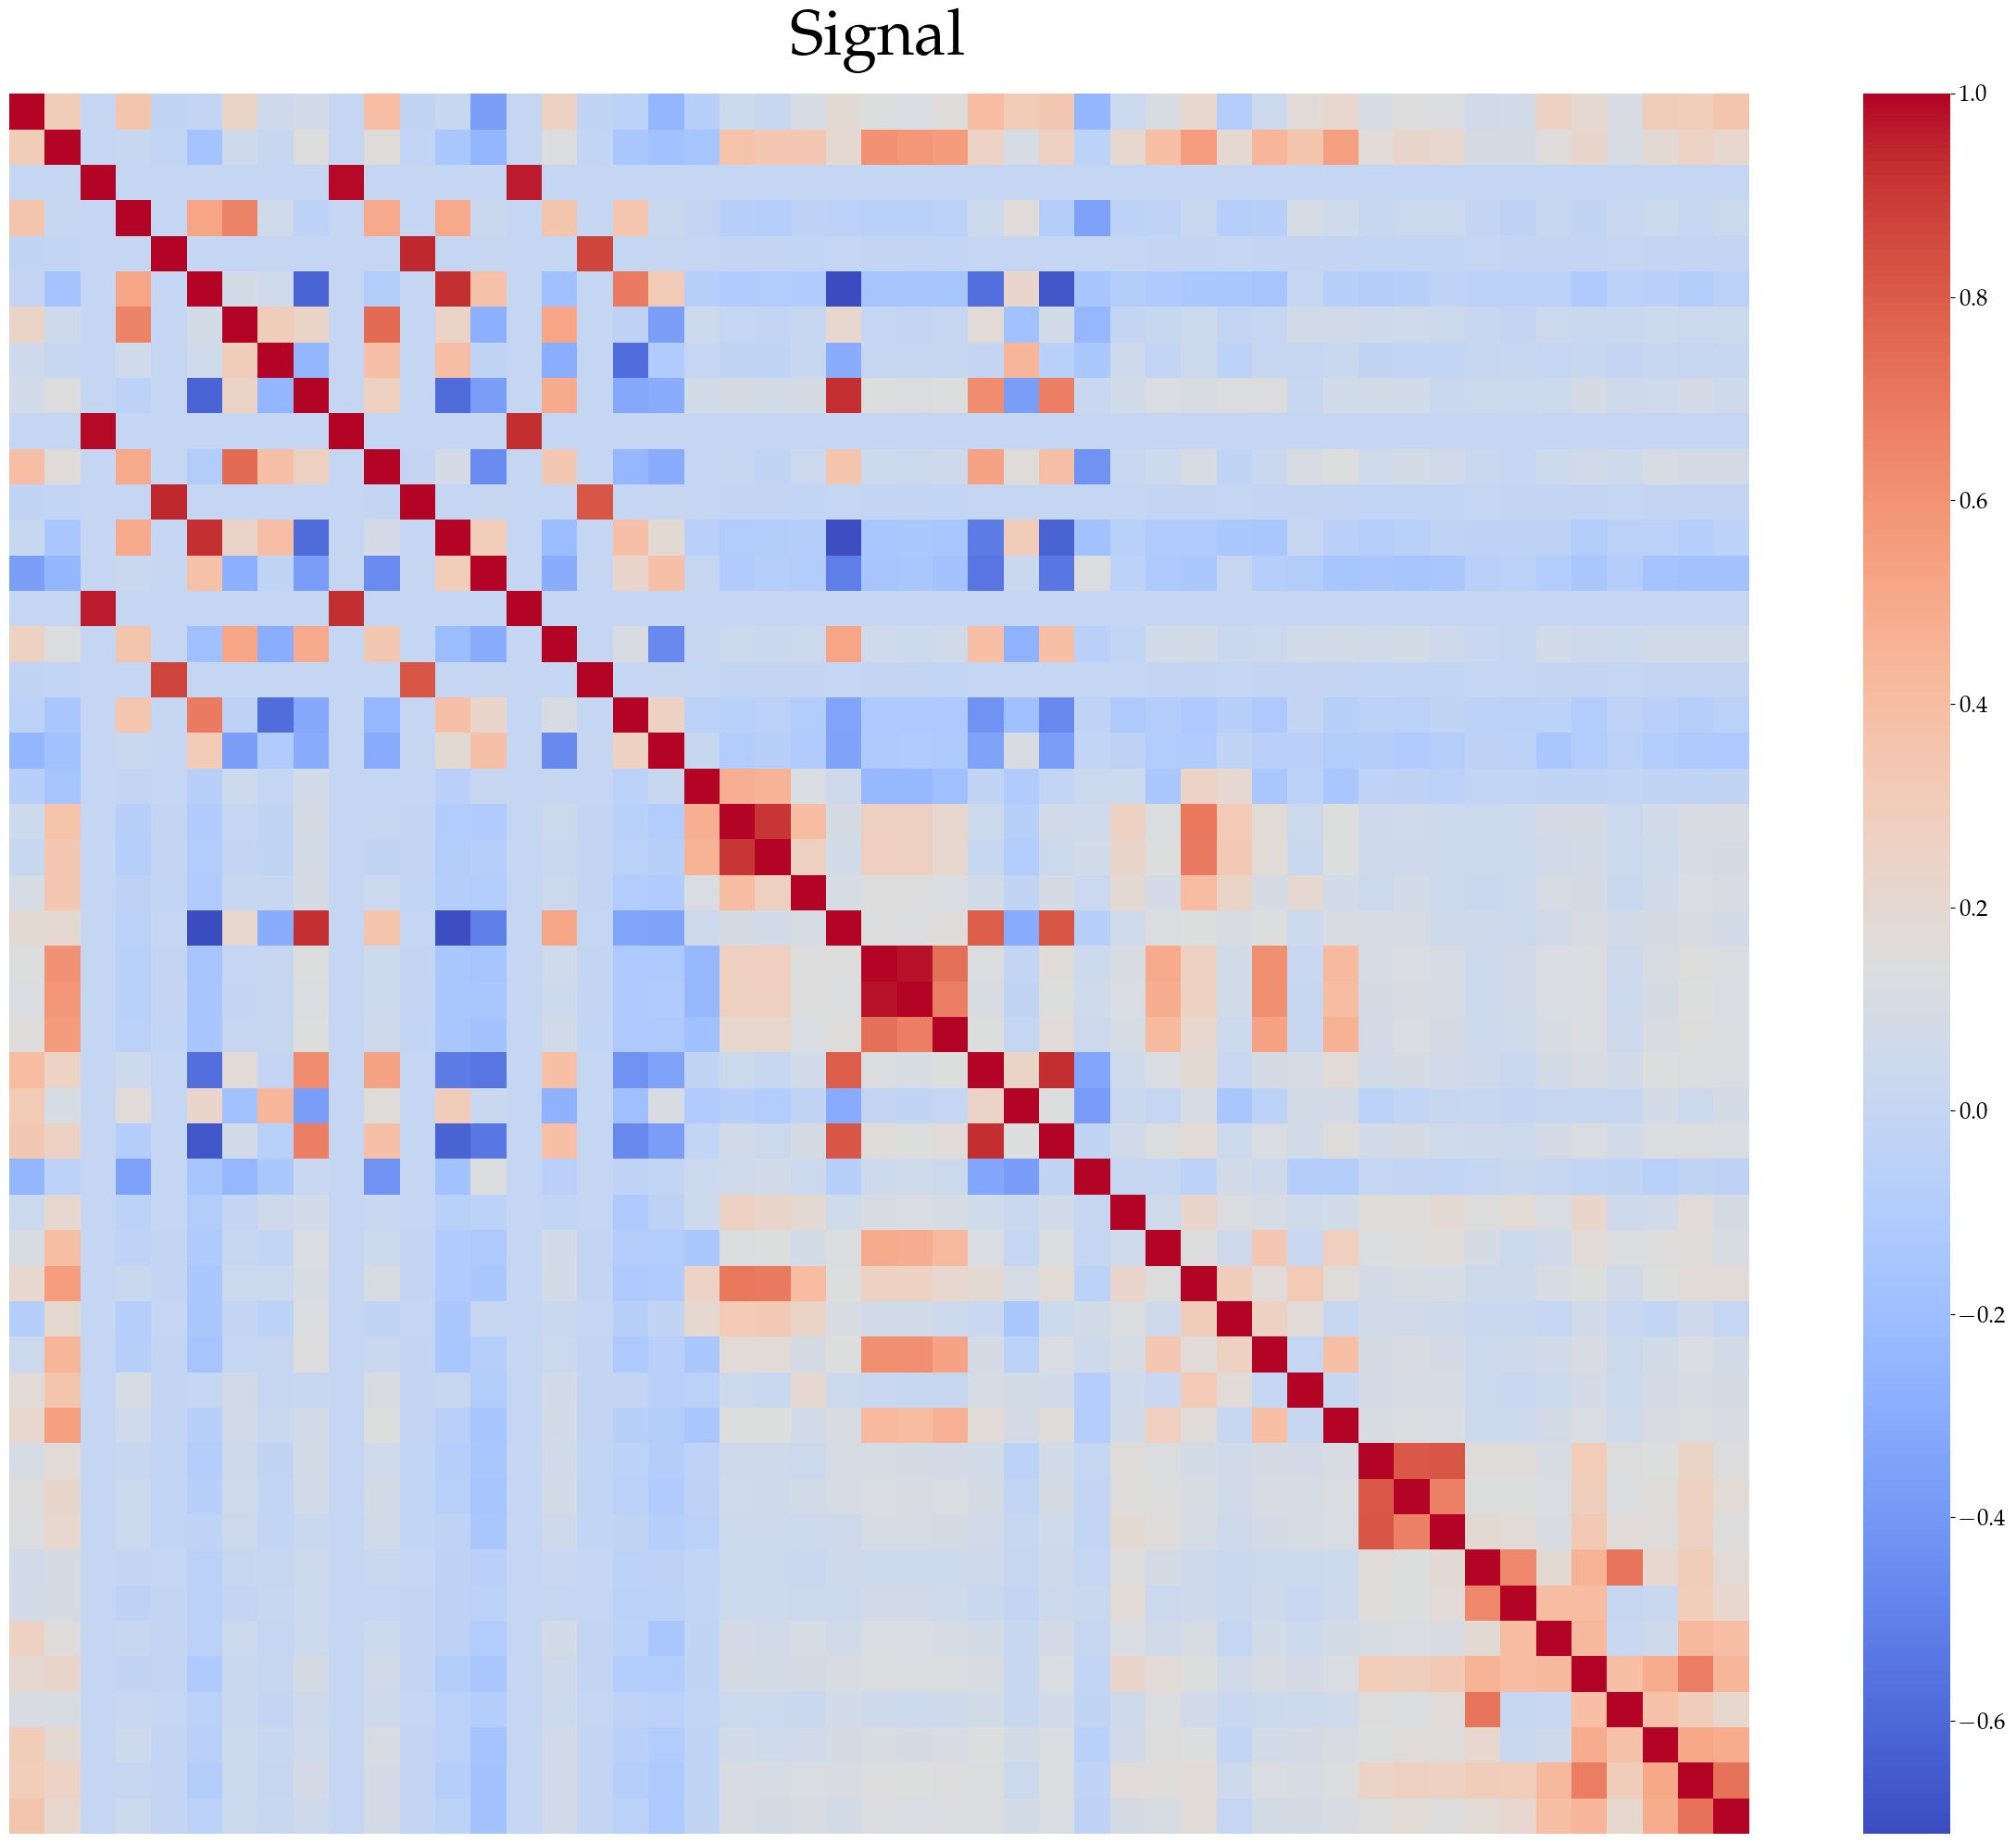

In [71]:
plt.figure(figsize=(25,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True,
            xticklabels=False, yticklabels=False)
plt.title('Signal', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_sig.pdf', bbox_inches='tight')
plt.show()

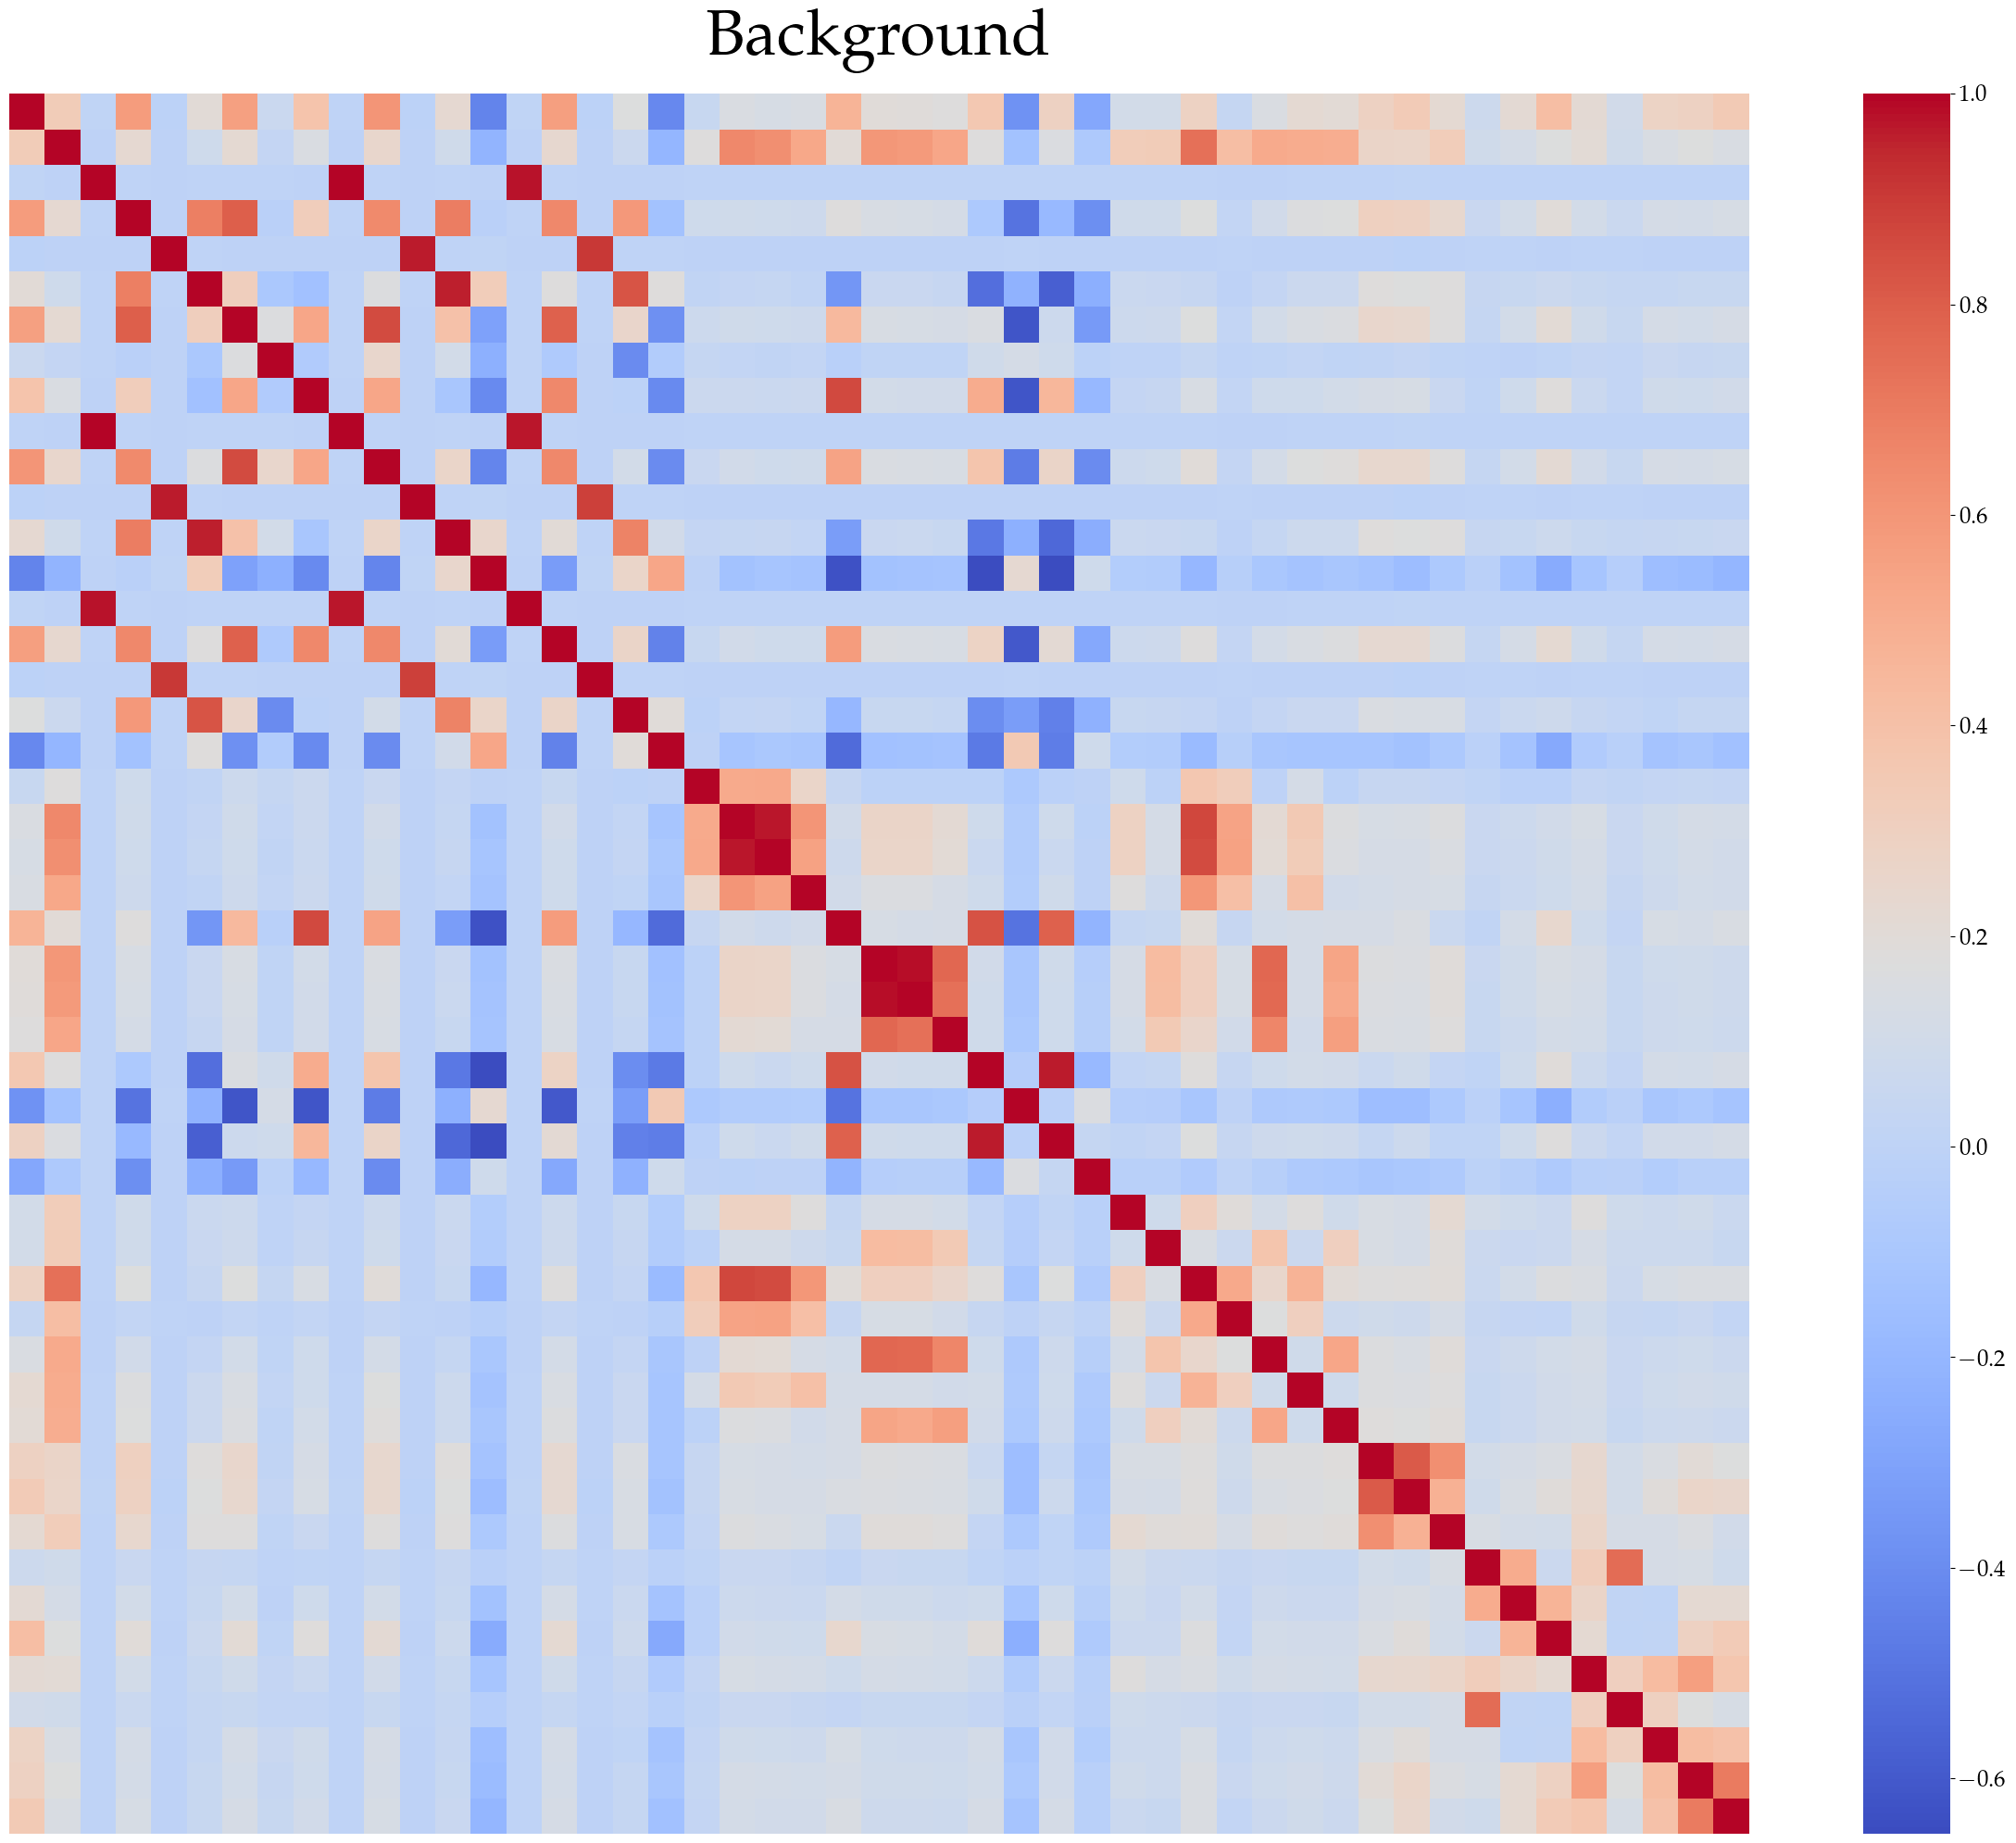

In [72]:
plt.figure(figsize=(25,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True, 
            xticklabels=False, yticklabels=False)
plt.title('Background', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_bkg.pdf', bbox_inches='tight')
plt.show()

In [73]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [74]:
del traindata

In [75]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [76]:
del testdata

In [77]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 599 ms, sys: 310 ms, total: 909 ms
Wall time: 910 ms


In [85]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [89]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

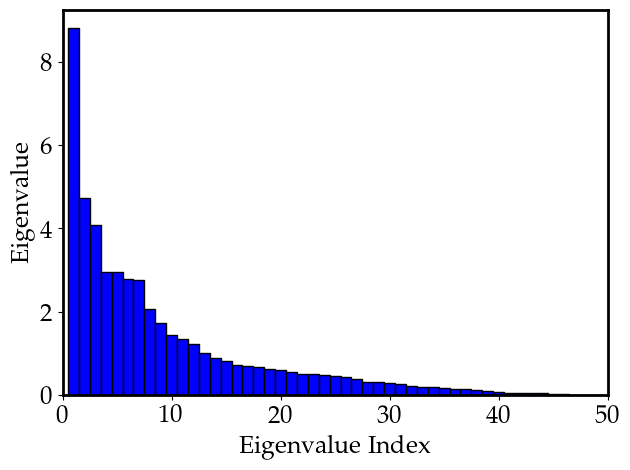

In [106]:
plt.figure()
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.tight_layout()
plt.savefig('plots/eigenvalues.pdf')
plt.show()

In [93]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[1.79727172e-01 9.67624777e-02 8.33795657e-02 6.05461840e-02
 6.01321313e-02 5.70894912e-02 5.61702304e-02 4.20812808e-02
 3.54223900e-02 2.96430791e-02 2.74874235e-02 2.48649580e-02
 2.07212355e-02 1.81910647e-02 1.64616610e-02 1.46405241e-02
 1.42502358e-02 1.36308267e-02 1.27623823e-02 1.24012207e-02
 1.15334612e-02 1.03913680e-02 1.02714035e-02 1.00229724e-02
 9.19051567e-03 8.71414378e-03 7.72812244e-03 6.41678555e-03
 6.28312954e-03 6.12451749e-03 5.42143103e-03 4.21933882e-03
 4.09815822e-03 3.77362451e-03 3.30696614e-03 3.03869328e-03
 2.75871999e-03 2.42118553e-03 2.08374554e-03 1.24616734e-03
 9.95061528e-04 9.05968960e-04 8.78488584e-04 8.29498513e-04
 3.69455032e-04 2.74665841e-04 1.94226171e-04 8.19543342e-05
 6.06970757e-05]
[0.17972717 0.27648965 0.35986922 0.4204154  0.48054753 0.53763702
 0.59380725 0.63588853 0.67131092 0.700954   0.72844143 0.75330638
 0.77402762 0.79221868 0.80868034 0.82332087 0.8375711  0.85120193
 0.86396431 0.87636553 0.887899   0.89829036 0.908

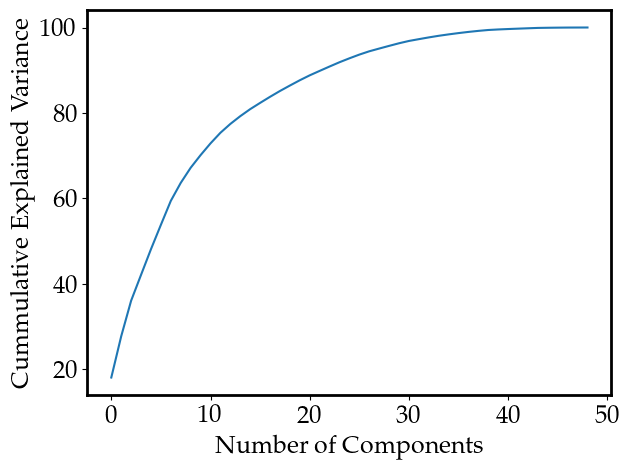

In [107]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.tight_layout()
plt.savefig('plots/pca_explained_variance.pdf')
plt.show()

In [98]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [99]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/49 [00:00<?, ?it/s]

fj_mass                          2.598622
fj_ptDR                          2.338079
fj_tau21                         2.227528
fj_trackSip2dSigAboveBottom_0    1.399741
fj_sdsj2_mass                    1.398802
fj_trackSip2dSigAboveCharm_0     1.171400
fj_sdsj1_mass                    1.165005
fj_sdsj2_pt                      1.140764
fj_sdn2                          1.098298
fj_trackSip2dSigAboveBottom_1    1.027311
fj_pt                            0.988874
fj_trackSipdSig_0                0.913851
fj_tau_flightDistance2dSig_0     0.855296
fj_tau_vertexEnergyRatio_0       0.756911
fj_trackSipdSig_0_0              0.708470
fj_nSV                           0.704348
fj_sdsj1_pt                      0.680893
fj_trackSipdSig_0_1              0.599895
fj_tau_vertexEnergyRatio_1       0.599157
fj_tau_vertexDeltaR_0            0.598707
fj_trackSipdSig_1                0.588927
fj_sdsj2_ptD                     0.563631
fj_tau1                          0.558423
fj_trackSipdSig_2                0

  0%|          | 0/6 [00:00<?, ?it/s]

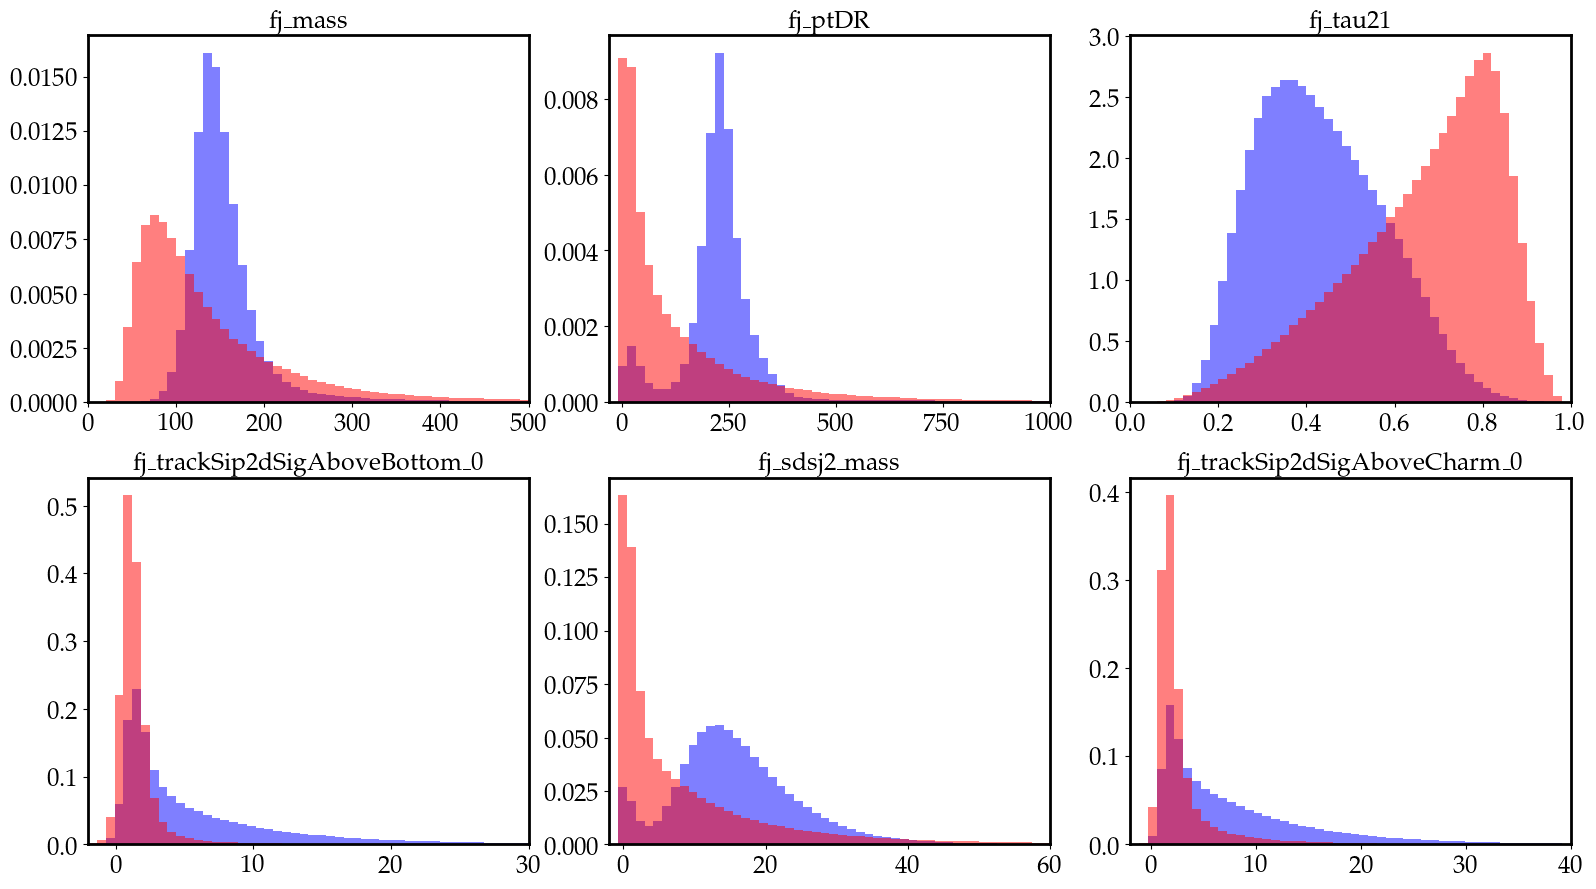

In [147]:
fig, axes = plt.subplots(2,3, figsize=(16,9))

features_to_plot = divergences.index.tolist()[:6]

lims = [(0,500),(-30,1000),(0,1),(-2,30),(-2,60),(-2,40)]

for ax, label, lim in tqdm(zip(axes.ravel(), features_to_plot, lims), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50, range=lim)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50, range=lim)
    ax.set_title(label,fontsize=18)
    ax.set_xlim(lim)
    
plt.tight_layout()
plt.savefig('plots/high_divergence_hists.pdf')
plt.show()

In [100]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [101]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [102]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(BatchNormalization(input_shape=(X_train_final.shape[1],)))
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 60)                3000      
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 6,978
Trainable params: 6,880
Non-trainable params: 98
_________________________________________________________________
None


In [103]:
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10


2022-11-08 00:01:44.747206: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


55/55 [==============================] - 1s 15ms/step - loss: 0.7683 - accuracy: 0.4468
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.7309 - accuracy: 0.5071
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6997 - accuracy: 0.5678
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6729 - accuracy: 0.6178
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6496 - accuracy: 0.6563
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6289 - accuracy: 0.6854
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6104 - accuracy: 0.7074
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5937 - accuracy: 0.7248
Epoch 9/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5785 - accuracy: 0.7387
Epoch 10/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5647 - accuracy: 0.7500
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.6529 - accuracy: 0.6507
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6176 - accuracy: 0.6989
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5883 - accuracy: 0.7298
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5634 - accuracy: 0.7509
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5420 - accuracy: 0.7663
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5233 - accuracy: 0.7780
Epoch 9/10
55/55 [==============================] - 1s 19ms/step - loss: 0.5068 - accuracy: 0.7875
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4922 - accuracy: 0.7951
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7523 - accuracy: 0.4724
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6917 - accuracy: 0.5828
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.5174 - accuracy: 0.7814
Epoch 6/10
55/55 [==============================] - 1s 18ms/step - loss: 0.4910 - accuracy: 0.7957
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4692 - accuracy: 0.8062
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4509 - accuracy: 0.8143
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4353 - accuracy: 0.8208
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4218 - accuracy: 0.8261
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7297 - accuracy: 0.5135
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.6423 - accuracy: 0.6651
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.5841 - accuracy: 0.7332
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5413 - accuracy: 0.7665
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.4010 - accuracy: 0.8342
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3850 - accuracy: 0.8403
Epoch 9/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3717 - accuracy: 0.8453
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3605 - accuracy: 0.8494
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6968 - accuracy: 0.5720
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5798 - accuracy: 0.7357
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5130 - accuracy: 0.7836
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4686 - accuracy: 0.8064
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4367 - accuracy: 0.8202
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4124 - accuracy: 0.8298
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.3238 - accuracy: 0.8629
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3166 - accuracy: 0.8657
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6522 - accuracy: 0.6370
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5089 - accuracy: 0.7853
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4413 - accuracy: 0.8181
Epoch 4/10
55/55 [==============================] - 1s 18ms/step - loss: 0.4006 - accuracy: 0.8343
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3729 - accuracy: 0.8448
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3531 - accuracy: 0.8521
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3386 - accuracy: 0.8574
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3277 - accuracy: 0.8614
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.5968 - accuracy: 0.6962
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4378 - accuracy: 0.8193
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3769 - accuracy: 0.8433
Epoch 4/10
55/55 [==============================] - 1s 18ms/step - loss: 0.3442 - accuracy: 0.8554
Epoch 5/10
55/55 [==============================] - 1s 20ms/step - loss: 0.3246 - accuracy: 0.8626
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3119 - accuracy: 0.8677
Epoch 7/10
55/55 [==============================] - 1s 18ms/step - loss: 0.3028 - accuracy: 0.8715
Epoch 8/10
55/55 [==============================] - 1s 19ms/step - loss: 0.2959 - accuracy: 0.8747
Epoch 9/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2902 - accuracy: 0.8775
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2855 - accuracy: 0.8799
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.3275 - accuracy: 0.8615
Epoch 4/10
55/55 [==============================] - 1s 18ms/step - loss: 0.3063 - accuracy: 0.8700
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2939 - accuracy: 0.8757
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2851 - accuracy: 0.8801
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2783 - accuracy: 0.8836
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2726 - accuracy: 0.8864
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2677 - accuracy: 0.8889
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2634 - accuracy: 0.8910
Epoch 1/10
55/55 [==============================] - 1s 19ms/step - loss: 0.5267 - accuracy: 0.7509
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3673 - accuracy: 0.8467
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2709 - accuracy: 0.8873
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2631 - accuracy: 0.8911
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2565 - accuracy: 0.8943
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2509 - accuracy: 0.8970
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2458 - accuracy: 0.8993
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2412 - accuracy: 0.9013
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4638 - accuracy: 0.7890
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3214 - accuracy: 0.8640
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2925 - accuracy: 0.8764
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2781 - accuracy: 0.8837
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 15ms/step - loss: 0.2339 - accuracy: 0.9044
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2279 - accuracy: 0.9069
Epoch 9/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2227 - accuracy: 0.9091
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2182 - accuracy: 0.9110
Epoch 1/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4070 - accuracy: 0.8184
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2915 - accuracy: 0.8770
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2697 - accuracy: 0.8879
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2564 - accuracy: 0.8944
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2463 - accuracy: 0.8990
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2380 - accuracy: 0.9027
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.2027 - accuracy: 0.9172
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1995 - accuracy: 0.9186
Epoch 1/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3612 - accuracy: 0.8408
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2687 - accuracy: 0.8884
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2479 - accuracy: 0.8983
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2338 - accuracy: 0.9044
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2233 - accuracy: 0.9089
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2153 - accuracy: 0.9121
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2092 - accuracy: 0.9146
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2045 - accuracy: 0.9165
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 18ms/step - loss: 0.3257 - accuracy: 0.8576
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2469 - accuracy: 0.8987
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2252 - accuracy: 0.9080
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2120 - accuracy: 0.9134
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2037 - accuracy: 0.9168
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2014 - accuracy: 0.9177
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1963 - accuracy: 0.9201
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1935 - accuracy: 0.9213
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1908 - accuracy: 0.9227
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1880 - accuracy: 0.9239
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2158 - accuracy: 0.9117
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2058 - accuracy: 0.9160
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1924 - accuracy: 0.9219
Epoch 6/10
55/55 [==============================] - 1s 18ms/step - loss: 0.1964 - accuracy: 0.9202
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1898 - accuracy: 0.9231
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1865 - accuracy: 0.9245
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1836 - accuracy: 0.9258
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1817 - accuracy: 0.9266
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3102 - accuracy: 0.8617
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2331 - accuracy: 0.9044
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 19ms/step - loss: 0.1910 - accuracy: 0.9223
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1869 - accuracy: 0.9242
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1857 - accuracy: 0.9248
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1811 - accuracy: 0.9268
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1805 - accuracy: 0.9272
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1776 - accuracy: 0.9285
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3140 - accuracy: 0.8623
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2268 - accuracy: 0.9065
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2061 - accuracy: 0.9154
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1995 - accuracy: 0.9183
Epoch 5/10
55/55 [==

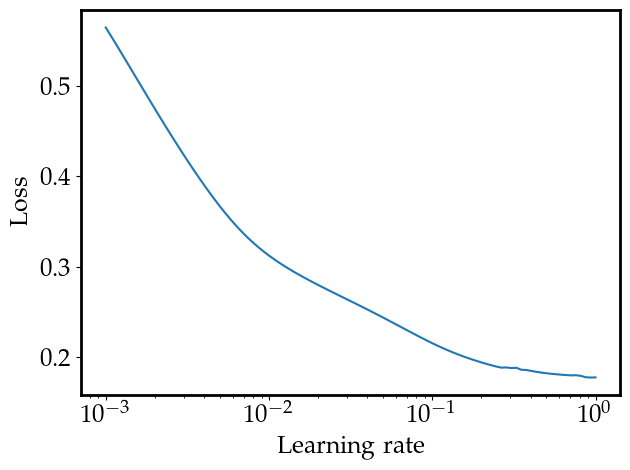

In [108]:
plt.figure()
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.tight_layout()
plt.savefig('plots/lr.pdf')
plt.show()

In [105]:
lr = rates[np.nanargmin(losses)]
print(lr)

0.9326033468832199


In [58]:
%%time
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, 
                          epochs=100, shuffle=False, callbacks = callbacks, 
                          validation_data=(X_test_final,y_test))

Epoch 1/100
55/55 [==============================] - 2s 24ms/step - loss: 0.3264 - accuracy: 0.8603 - val_loss: 0.2280 - val_accuracy: 0.9065
Epoch 2/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2259 - accuracy: 0.9067 - val_loss: 0.2071 - val_accuracy: 0.9157
Epoch 3/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2108 - accuracy: 0.9134 - val_loss: 0.2163 - val_accuracy: 0.9106
Epoch 4/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2016 - accuracy: 0.9177 - val_loss: 0.1932 - val_accuracy: 0.9222
Epoch 5/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1944 - accuracy: 0.9209 - val_loss: 0.1975 - val_accuracy: 0.9199
Epoch 6/100
55/55 [==============================] - 1s 19ms/step - loss: 0.1897 - accuracy: 0.9232 - val_loss: 0.1840 - val_accuracy: 0.9262
Epoch 7/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1862 - accuracy: 0.9248 - val_loss: 0.1900 - val_accuracy: 0.9234
Epoch 

In [59]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

In [60]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 287us/step


In [61]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

In [62]:
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 41s 367us/step - loss: 0.1490 - accuracy: 0.9410
[0.14898480474948883, 0.9410288333892822]
13921/13921 [==============================] - 5s 367us/step - loss: 0.1510 - accuracy: 0.9407
[0.1510068029165268, 0.9407269954681396]


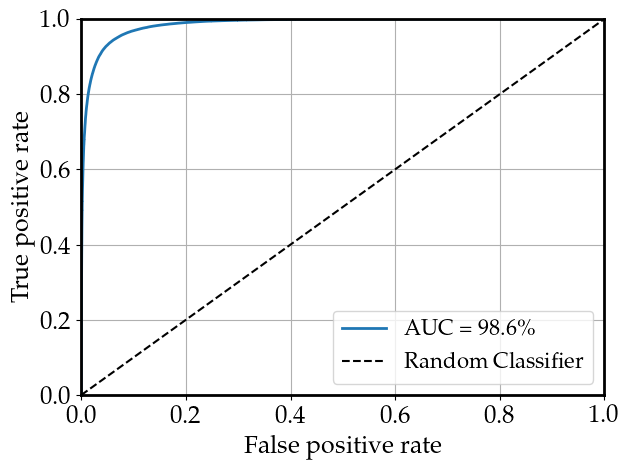

In [63]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_combined.pdf')
plt.show()

In [64]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_combined.pdf')

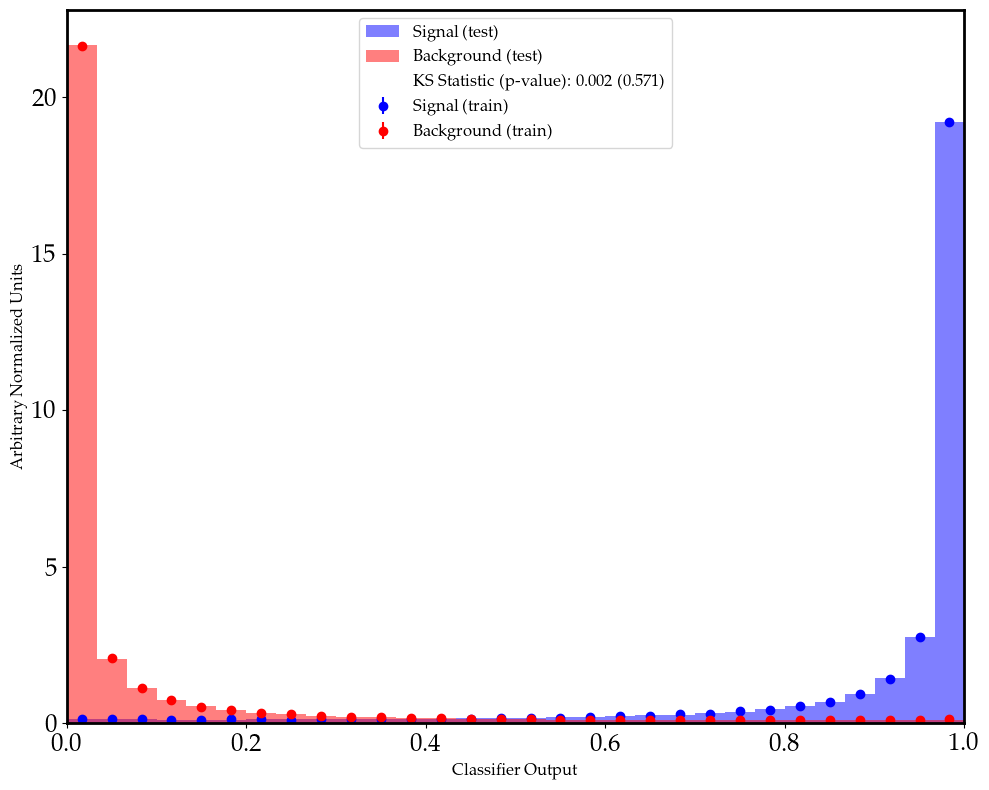

In [65]:
fig

In [66]:
bdt = XGBClassifier(booster='gbtree')

In [67]:
%%time
bdt.fit(X_train_final.to_numpy(), y_train.to_numpy())

CPU times: user 1h 43min 58s, sys: 54.8 s, total: 1h 44min 53s
Wall time: 10min 57s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [68]:
print(bdt.score(X_train_final.to_numpy(), y_train.to_numpy()))
print(bdt.score(X_test_final.to_numpy(), y_test.to_numpy()))

0.9454404112819863
0.9434544654562433


In [69]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

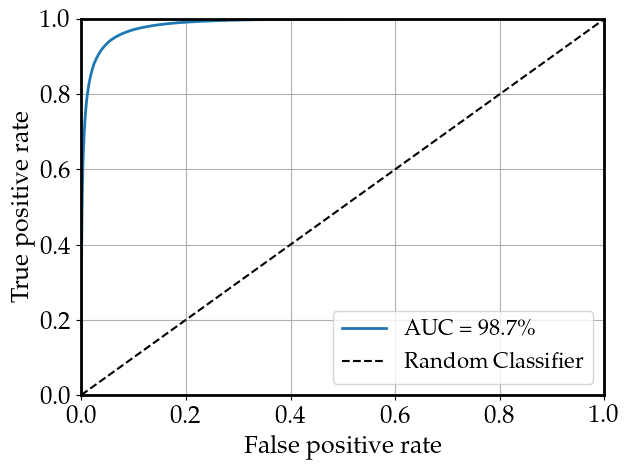

In [70]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_combined.pdf')
plt.show()

In [71]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_combined.pdf')

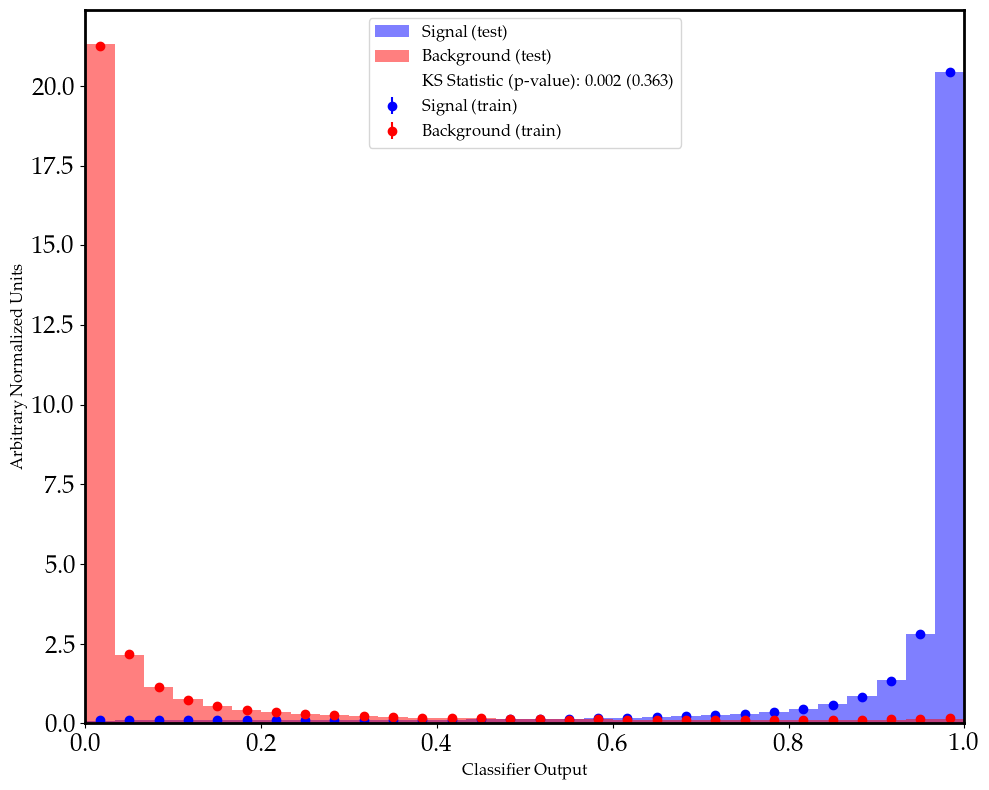

In [72]:
fig

In [73]:
fisher = LinearDiscriminantAnalysis()

In [74]:
%%time
fisher.fit(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

CPU times: user 28.5 s, sys: 4.39 s, total: 32.9 s
Wall time: 14.5 s


LinearDiscriminantAnalysis()

In [75]:
print(fisher.score(X_train_final.to_numpy(), y_train.to_numpy()[:,0]))
print(fisher.score(X_test_final.to_numpy(), y_test.to_numpy()[:,0]))

0.8585281502799071
0.8586664691198391


In [76]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,1])

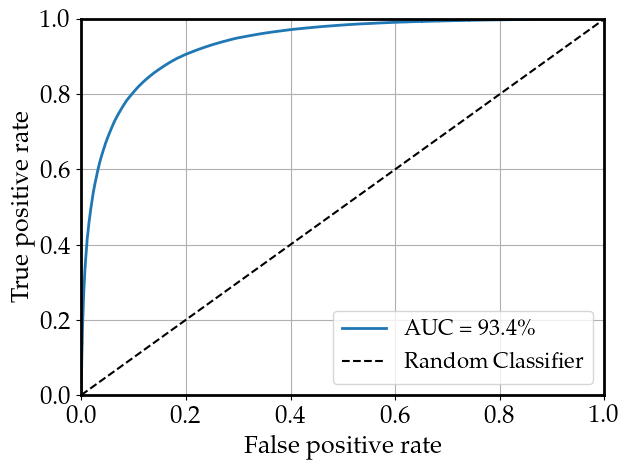

In [77]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_combined.pdf')
plt.show()

In [78]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,1],
                   y_test.to_numpy()[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_combined.pdf')

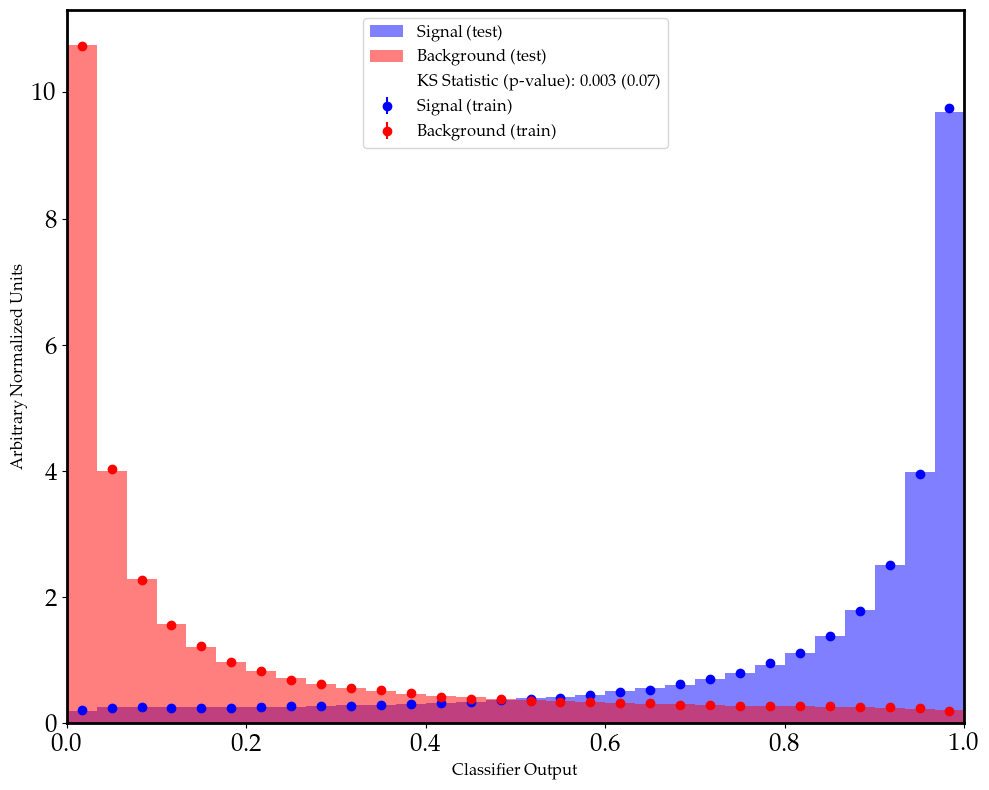

In [79]:
fig